# Quality control of RAW data 

In this chapter, we will download some RAW acquistions obtained in core facility and we will look at some specific MS information such as Total Ion Chromatorams, Base Peak Chromatograms, Extract Ion Chromatograms, number of fragmented precursor ions and so on.
This will help us to check for eventual issues related to the sample prepration and the MS acquisition.


### Getting the data

From your terminal, go to a specific folder that will use as a workspace.
Note: on this computer the workspace path is defined as "/mnt/". So please change this prefix according to your configuration in the future sections of this tutorial. 

From your workspace folder type to download the raw data:

`wget http://proteomique.ipbs.fr/ibip19/raw_data_ibip19.7z`

TODO: wget http://proteomique.ipbs.fr/ibip19/OECPI190330_43.raw.7z or update the initial archive


Then to extract the files type:

`
sudo apt install p7zip-full
7z x raw_data_ibip19.7z
`

The first command will install the 7zip software and the second one will use this tool to unzip the data.

Once unzipped should see the following file hierarchy on your system:

```
mnt
│
└───cytoc
│   │   OVKAC141014_60.raw.mzDB
│   │   OVKAC141014_88.raw.mzDB
│   │   QEKAC141027_67.raw.mzDB
│   │   QEKAC141106_158.raw.mzDB
│   │   QEKAC141106_170.raw.mzDB
└───hela
│   │   OECCF190314_03.raw.mzDB
│   │   OVKAC190318_11.raw.mzDB
│   │   OVMMA190417_13.raw.mzDB
└───samples
    │   OECPI181123_10.raw.mzDB
    │   OECPI190322_06.raw.mzDB
    │   OECPI190322_09.raw.mzDB
```

This mzDB files correspond to the raw data LC-MS/MS acquisitions from different Thermo instruments (OV = Orbitrap Velos, QE =  OE = Orbitrap Velos ETD, QExactive+). These files were obtained by converting the input .raw files into the open-source mzDB file format (https://github.com/mzdb/mzdb-specs, https://www.mcponline.org/content/early/2014/12/11/mcp.O114.039115.abstract).

We will use some R packages to query these mzDB files and perform some basic quality control.

### Installing the packages

We will use two packages to read the mzDB files: RSQLite and rmzdb. Execute the following R commands to install them:

In [1]:
#install.packages("RSQLite")
#install.packages("https://github.com/mzdb/rmzdb/releases/download/0.1.1/rmzdb_0.1.1.tar.gz", type="source", repo=NULL, INSTALL_opts=c("--no-multiarch"))

### Loading the packages

To load the packages run:

In [2]:
library(RSQLite)
library(rmzdb)

### Browsing mzDB files

mzDB files are implemented as SQLite database files. If you want to see the full database schema you can have a look at this file https://github.com/mzdb/mzdb-specs/blob/master/version_0.7.0/mzDB_0.7.0_schema_picture.pdf). To open the files run:

In [3]:
OECCF190314_03 <- "/mnt/hela/OECCF190314_03.raw.mzDB"
OVKAC190318_11 <- "/mnt/hela/OVKAC190318_11.raw.mzDB"
OVMMA190417_13 <- "/mnt/hela/OVMMA190417_13.raw.mzDB"

sqlite_OECCF190314_03 <- dbConnect(RSQLite::SQLite(), OECCF190314_03)
sqlite_OVKAC190318_11 <- dbConnect(RSQLite::SQLite(), OVKAC190318_11)
sqlite_OVMMA190417_13 <- dbConnect(RSQLite::SQLite(), OVMMA190417_13)

The next two lines we allow us to inspect the tables present in an mzDB file and also the field present in the spectrum table (it should be consistent with what you have seen in 'mzDB_0.7.0_schema_picture.pdf'):

In [4]:
dbListTables(sqlite_OECCF190314_03)
dbListFields(sqlite_OECCF190314_03,"spectrum")

[1] "bounding_box"                  "bounding_box_msn_rtree"       
 [3] "bounding_box_msn_rtree_node"   "bounding_box_msn_rtree_parent"
 [5] "bounding_box_msn_rtree_rowid"  "bounding_box_rtree"           
 [7] "bounding_box_rtree_node"       "bounding_box_rtree_parent"    
 [9] "bounding_box_rtree_rowid"      "chromatogram"                 
[11] "cv"                            "cv_term"                      
[13] "cv_unit"                       "data_encoding"                
[15] "data_processing"               "instrument_configuration"     
[17] "mzdb"                          "param_tree_schema"            
[19] "processing_method"             "run"                          
[21] "run_slice"                     "sample"                       
[23] "scan_settings"                 "shared_param_tree"            
[25] "software"                      "source_file"                  
[27] "source_file_scan_settings_map" "spectrum"                     
[29] "sqlite_sequence"               "table_param_tree_schema"      
[31] "target"                        "user_term"

[1] "id"                          "initial_id"                 
 [3] "title"                       "cycle"                      
 [5] "time"                        "ms_level"                   
 [7] "activation_type"             "tic"                        
 [9] "base_peak_mz"                "base_peak_intensity"        
[11] "main_precursor_mz"           "main_precursor_charge"      
[13] "data_points_count"           "param_tree"                 
[15] "scan_list"                   "precursor_list"             
[17] "product_list"                "shared_param_tree_id"       
[19] "instrument_configuration_id" "source_file_id"             
[21] "run_id"                      "data_processing_id"         
[23] "data_encoding_id"            "bb_first_spectrum_id"

The spectrum table is main of the mzDB file. It contains the meta-data of MS and MS/MS spectrum. Some columns (param_tree,scan_list,precursor_list,product_list) contains information stored in the XML format. Since it is not easy to query this information we will not use it. Columns finishing with 'id' are also not very useful. Useful columns are thus: title, cycle, time, ms_level, activation_type, tic, base_peak_mz, base_peak_intensity, main_precursor_mz, main_precursor_charge, data_points_count.

### Comparing HeLa complex mixtures

The 3 provided files (OECCF190314_03, OVKAC190318_11, OVMMA190417_13) correspond to an HeLa cell lysate which has been injected at different time points. This kind of human mixture is very complex and thus quite challenging for our mass spectrometers. It's a perfect way to assess the "good health" of our instruments. Note that all the anlyses we will perform in this section could also be applied on "real samples" (i.e. on your own MS acquistions).

To verify if the MS acquistions were performed correctly, we will make some basic plots.
We will use simple SQL queries to access these data. We will start to have a look at the number of MS/MS events:

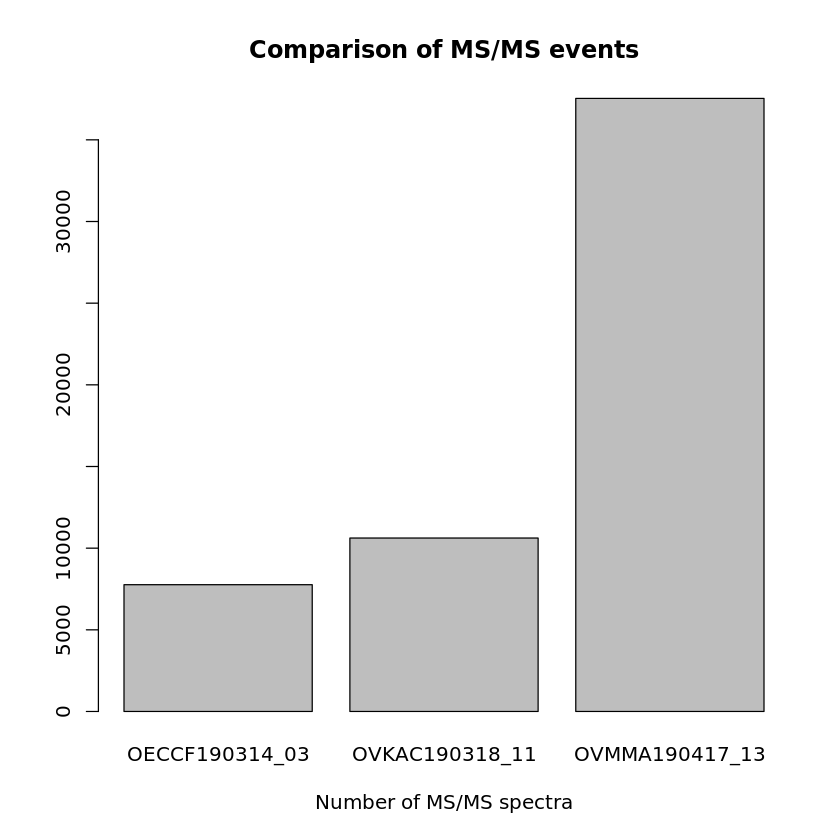

In [5]:
OECCF190314_03_ms2_count <- dbGetQuery(sqlite_OECCF190314_03, "SELECT count(*) as n FROM spectrum WHERE ms_level = 2")
OVKAC190318_11_ms2_count <- dbGetQuery(sqlite_OVKAC190318_11, "SELECT count(*) as n FROM spectrum WHERE ms_level = 2")
OVMMA190417_13_ms2_count <- dbGetQuery(sqlite_OVMMA190417_13, "SELECT count(*) as n FROM spectrum WHERE ms_level = 2")

hela_ms2_count <- c(OECCF190314_03_ms2_count$n,OVKAC190318_11_ms2_count$n,OVMMA190417_13_ms2_count$n)
barplot(hela_ms2_count, main="Comparison of MS/MS events",  xlab="Number of MS/MS spectra",
        names.arg=c("OECCF190314_03", "OVKAC190318_11", "OVMMA190417_13")
       )

#### Add your answers here
(double-click here to edit the cell)

##### Question I:  <ins>How similar are the MS acquisitions in terms of the number of MS/MS events?</ins>

_Answer_

##### Question II:  <ins>Since we know the same sample was injected thre times, would you expect this result?</ins>

_Answer_

##### Question III:  <ins>Is it easy to draw a conclusion from this single figure?</ins>

_Answer_



Try to perform the same analysis at the MS level using the next cell of code (you can get inspiration from the last example):

#### Add your answers here
(double-click here to edit the cell)

##### Question:  <ins>Are these results in agreement with your previous observations?</ins>

_Answer_



To have a better idea of what went wrong, you will execute the following lines to create a Total Ion Chromatgram (TIC) of each acquisition file:

In [6]:
OECCF190314_03_ms1_tic <- dbGetQuery(sqlite_OECCF190314_03, "SELECT (time / 60) as rt, tic as intensity FROM spectrum WHERE ms_level = 1")
OVKAC190318_11_ms1_tic <- dbGetQuery(sqlite_OVKAC190318_11, "SELECT (time / 60) as rt, tic as intensity FROM spectrum WHERE ms_level = 1")
OVMMA190417_13_ms1_tic <- dbGetQuery(sqlite_OVMMA190417_13, "SELECT (time / 60) as rt, tic as intensity FROM spectrum WHERE ms_level = 1")

Then to plot the retrieved TICs run:

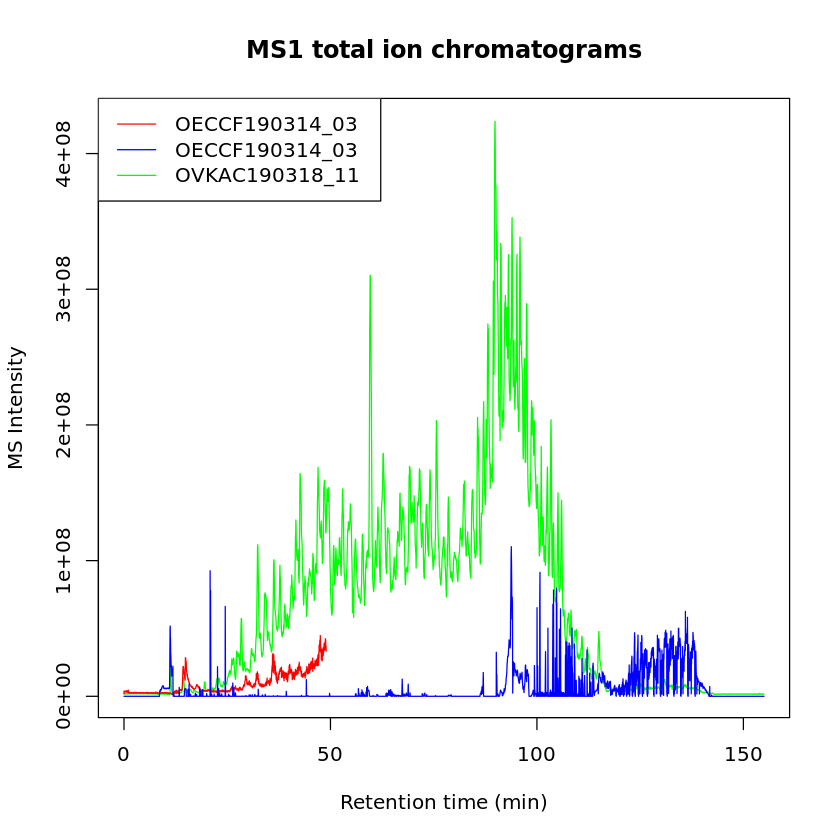

In [7]:
plot(OVMMA190417_13_ms1_tic$rt,OVMMA190417_13_ms1_tic$intensity, type="l", col="green", lwd=1, xlab="Retention time (min)", ylab="MS Intensity", main = "MS1 total ion chromatograms") 
lines(OECCF190314_03_ms1_tic$rt,OECCF190314_03_ms1_tic$intensity, type="l", col="red", lwd=1)
lines(OVKAC190318_11_ms1_tic$rt,OVKAC190318_11_ms1_tic$intensity, type="l", col="blue", lwd=1)
legend("topleft",c("OECCF190314_03","OECCF190314_03", "OVKAC190318_11"), lwd=c(1,1), col=c("red","blue","green"))

#### Add your answers here
(double-click here to edit the cell)

##### Question I:  <ins>How similar are the chromatograms?</ins>

_Answer_

##### Question II:  <ins>Considering these results and the previous ones, which MS acquisition would you consider as a valid one?</ins>

_Answer_

##### Question III:  <ins>What are your hypotheses regarding issues which may have occurred in the other acquistions?</ins>

_Answer_



Use the next cell to do the same analysis at the MS2 level in order to verify these observations:

Finally disconnect from the mzDB files to free allocated computer resources.

In [8]:
### Disconnect from database ###
dbDisconnect(sqlite_OECCF190314_03)
dbDisconnect(sqlite_OVKAC190318_11)
dbDisconnect(sqlite_OVMMA190417_13)

### Doing QC on standard samples

In the last section we have made some quality control of HeLa cells mixture acquistions. While this is a popular solution, another one consists in injecting periodically a digest of a given standard protein such as the Bovine serum albumin, the Cytochrome C or the Myoglobin. The main advantage of this kind of sample is not it can be interleaved with your sample of interest without "polluting" too much the liquid chromatography system (carry over issue). It's thus a nice way to monitor your instrument in almost real-time.

In this section we will use the rmzdb library to query some Cytochrome C sample acquisitions and then assess the health of the LC-MS chain.

Let's start by opening the files:

In [9]:
QEKAC141027_67 <- "/mnt/cytoc/QEKAC141027_67.raw.mzDB"
OVKAC141014_60 <- "/mnt/cytoc/OVKAC141014_60.raw.mzDB"
OVKAC141014_88 <- "/mnt/cytoc/OVKAC141014_88.raw.mzDB"
QEKAC141106_158 <- "/mnt/cytoc/QEKAC141106_158.raw.mzDB"
QEKAC141106_170 <- "/mnt/cytoc/QEKAC141106_170.raw.mzDB"

mzdb_QEKAC141027_67 <- new(MzDb, QEKAC141027_67)
mzdb_OVKAC141014_60 <- new(MzDb, OVKAC141014_60)
mzdb_OVKAC141014_88 <- new(MzDb, OVKAC141014_88)
mzdb_OVKAC141014_158 <- new(MzDb, QEKAC141106_158)
mzdb_OVKAC141014_170 <- new(MzDb, QEKAC141106_170)

In the next cell we define the m/z values of the Cytochrome C peptide ions. We will use these values later to peform extract some chromatograms.

In [10]:
KYPGTK_mz <- 403.7422
KIFVQK_mz <- 381.7473
KTGQAPGFSYTDANK_mz_z2 <- 792.8863
KTGQAPGFSYTDANK_mz_z3 <- 528.9266
KGEREDLIAYLK_mz <- 717.9012
TGPNLHGLFGR_mz_z2 <- 584.8147
TGPNLHGLFGR_mz_z3 <- 390.2122
MIFAGIK_mz <- 390.2278

To generate the chromatograms we need to create an extractor for each mzDB file, as follow:

In [11]:
chromx_QEKAC141027_67 <- new (MzDbExtractor, mzdb_QEKAC141027_67)
chromx_OVKAC141014_60 <- new (MzDbExtractor, mzdb_OVKAC141014_60)
chromx_OVKAC141014_88 <- new (MzDbExtractor, mzdb_OVKAC141014_88)
chromx_OVKAC141014_158 <- new (MzDbExtractor, mzdb_OVKAC141014_158)
chromx_OVKAC141014_170 <- new (MzDbExtractor, mzdb_OVKAC141014_170)

We will then call the "get_xic" method to extract the signals. This method takes 6 parameters:
* the ion m/z value
* the ion m/z tolerance
* the minimum retention time
* the maximum retention time
* the MS level
* the SWATH/DIA precursor m/z value (not useful here, so we put -1)

Let's start with a simple XIC example on the file named QEKAC141027_67:

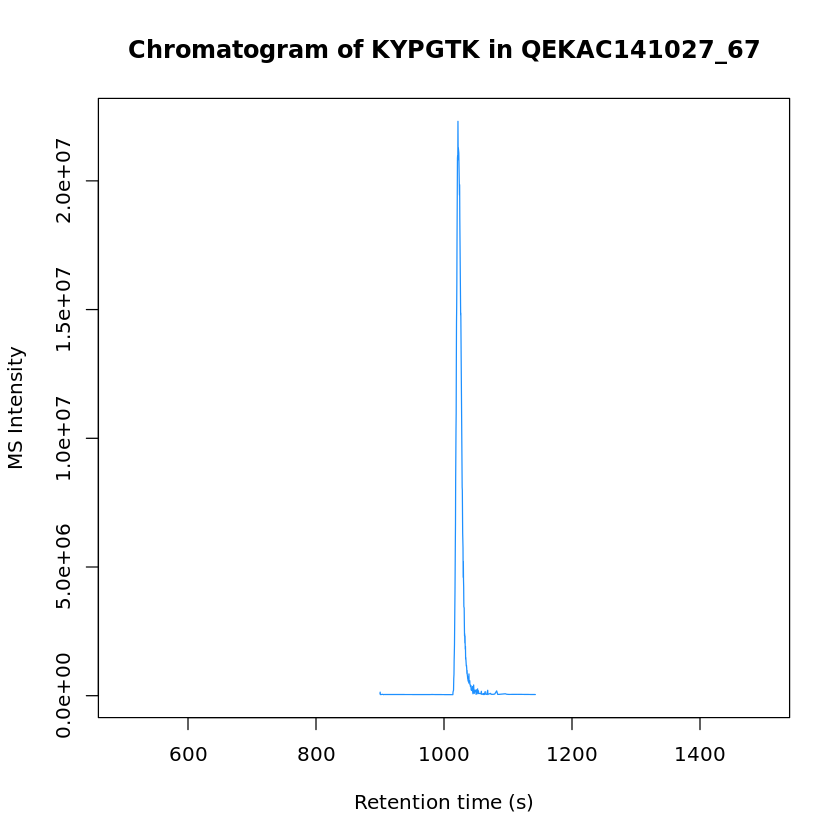

In [12]:
KYPGTK_67_chrom <- chromx_QEKAC141027_67$get_xic(KYPGTK_mz,0.001,500,1500,1,-1)

plot(KYPGTK_67_chrom[,1],KYPGTK_67_chrom[,2], type="l", col="dodgerblue", lwd=1, xlab="Retention time (s)", ylab="MS Intensity",xlim=c(500,1500), main="Chromatogram of KYPGTK in QEKAC141027_67")

The previous plot corresponds to what we could expect when there is no LC-MS issue. You can use this a reference.

Let's make some quality control other mzDB file. We will query the same ion:

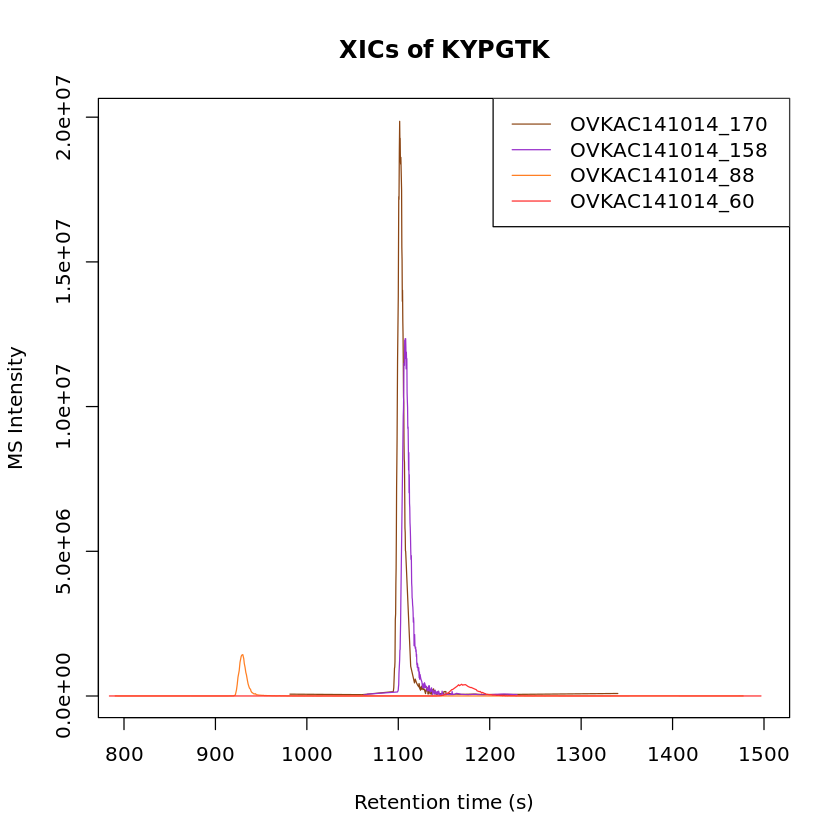

In [13]:
KYPGTK_60_chrom <- chromx_OVKAC141014_60$get_xic(KYPGTK_mz,0.001,500,1500,1,-1)
KYPGTK_88_chrom <- chromx_OVKAC141014_88$get_xic(KYPGTK_mz,0.001,500,1500,1,-1)
KYPGTK_158_chrom <- chromx_OVKAC141014_158$get_xic(KYPGTK_mz,0.001,500,1500,1,-1)
KYPGTK_170_chrom <- chromx_OVKAC141014_170$get_xic(KYPGTK_mz,0.001,500,1500,1,-1)

### Before/after needle change ###
plot(KYPGTK_170_chrom[,1],KYPGTK_170_chrom[,2], type="l", col="chocolate4", lwd=1, xlim=c(800,1500), xlab="Retention time (s)", ylab="MS Intensity", main = "XICs of KYPGTK")
lines(KYPGTK_158_chrom[,1],KYPGTK_158_chrom[,2], type="l", col="darkorchid", lwd=1)
lines(KYPGTK_88_chrom[,1],KYPGTK_88_chrom[,2], type="l", col="chocolate1", lwd=1)
lines(KYPGTK_60_chrom[,1],KYPGTK_60_chrom[,2], type="l", col="firebrick1", lwd=1)
legend("topright",c("OVKAC141014_170","OVKAC141014_158", "OVKAC141014_88", "OVKAC141014_60"), lwd=c(1,1), col=c("chocolate4","darkorchid","chocolate1","firebrick1"))

Let's query another ion in the reference file:

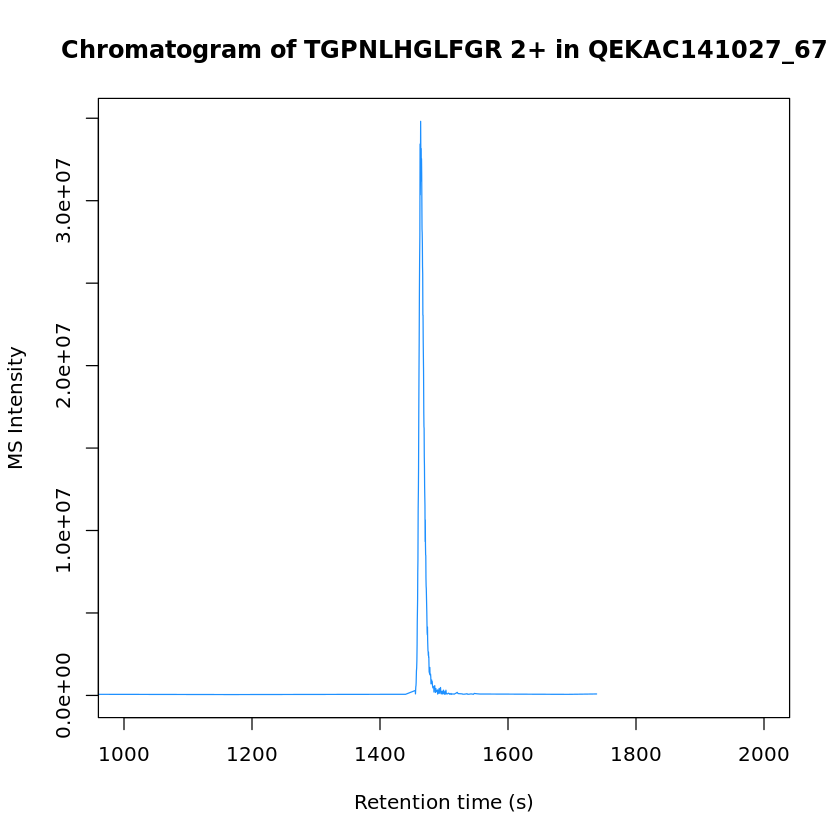

In [14]:
TGPNLHGLFGR_67_chrom <- chromx_QEKAC141027_67$get_xic(TGPNLHGLFGR_mz_z2,0.002,500,3000,1,-1)

plot(TGPNLHGLFGR_67_chrom[,1],TGPNLHGLFGR_67_chrom[,2], type="l", col="dodgerblue", lwd=1, xlab="Retention time (s)", ylab="MS Intensity",xlim=c(1000,2000), main="Chromatogram of TGPNLHGLFGR 2+ in QEKAC141027_67")

Let's query this second ion in other files:

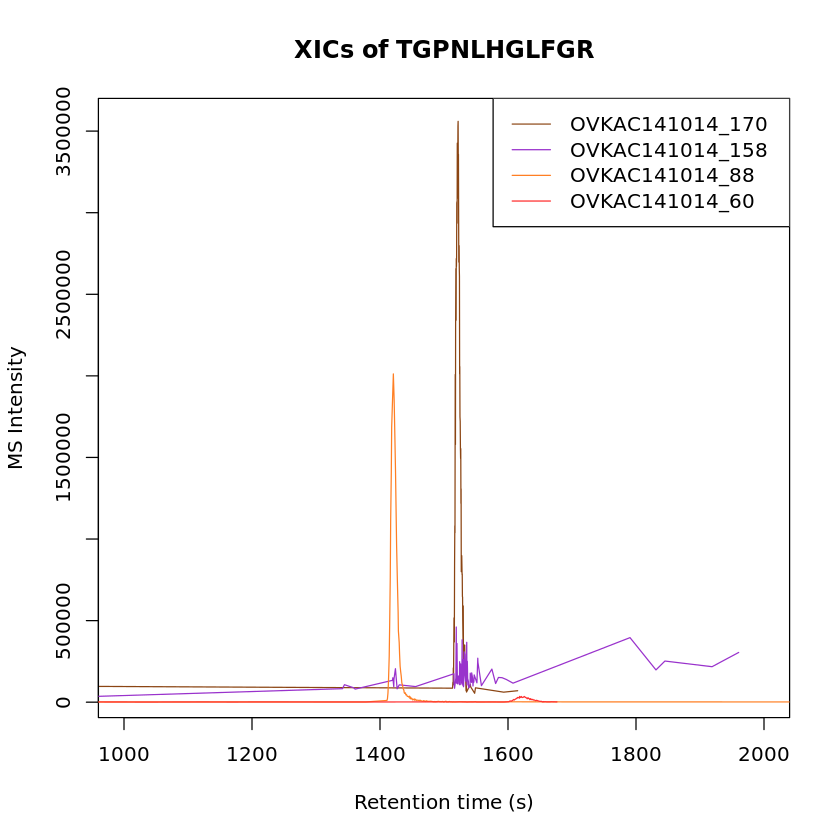

In [15]:
TGPNLHGLFGR_60_chrom <- chromx_OVKAC141014_60$get_xic(TGPNLHGLFGR_mz_z2,0.002,500,3000,1,-1)
TGPNLHGLFGR_88_chrom <- chromx_OVKAC141014_88$get_xic(TGPNLHGLFGR_mz_z2,0.002,500,3000,1,-1)
TGPNLHGLFGR_158_chrom <- chromx_OVKAC141014_158$get_xic(TGPNLHGLFGR_mz_z2,0.002,500,3000,1,-1)
TGPNLHGLFGR_170_chrom <- chromx_OVKAC141014_170$get_xic(TGPNLHGLFGR_mz_z2,0.002,500,3000,1,-1)

plot(TGPNLHGLFGR_170_chrom[,1],TGPNLHGLFGR_170_chrom[,2], type="l", col="chocolate4", lwd=1, xlim=c(1000,2000), xlab="Retention time (s)", ylab="MS Intensity", main = "XICs of TGPNLHGLFGR")
lines(TGPNLHGLFGR_158_chrom[,1],TGPNLHGLFGR_158_chrom[,2], type="l", col="darkorchid", lwd=1)
lines(TGPNLHGLFGR_88_chrom[,1],TGPNLHGLFGR_88_chrom[,2], type="l", col="chocolate1", lwd=1)
lines(TGPNLHGLFGR_60_chrom[,1],TGPNLHGLFGR_60_chrom[,2], type="l", col="firebrick1", lwd=1)
legend("topright",c("OVKAC141014_170","OVKAC141014_158", "OVKAC141014_88", "OVKAC141014_60"), lwd=c(1,1), col=c("chocolate4","darkorchid","chocolate1","firebrick1"))

#### Add your answers here
(double-click here to edit the cell)

##### Question I:  <ins>How similar are the XICs between the different mzDB files?</ins>

_Answer_

##### Question II:  <ins>Considering these chromatograms observed in the reference file, which MS acquisition would you consider as a valid one?</ins>

_Answer_

##### Question III:  <ins>What are your hypotheses regarding issues which may have occurred in the other acquistions?</ins>

_Answer_



### Doing QC on real samples

In the last two sections we have used two kind of samples dedicated to quality control. This helped us to monitor our LC-MS setup and to be sure that we performed our acquisitions in optimal conditions.

Now we are ging inspect the RAW data of real samples coming from an immunoprecipitation experiment. The goal of the project is to do find partners of the JAL34 protein in "Arabidopsis thaliana" cells. A first experiment was performed in November 2018 (OECPI181123_10.raw) and led to the identification of 288 proteins. The same expriment was done again in March 2019 (OECPI190322_06.raw) and we only identified/validated 2 proteins is this second analysis. And HeLa cell mixture was also analyzed in parallel to verify that the instrument was working correctly (file OECPI190322_09.raw).

We will reuse our skills in raw data quality control to try to understand what could explain this decrease in terms of protein identification.

Let's start by opening the files:

In [16]:
sample1811 <- "/mnt/samples/OECPI181123_10.raw.mzDB"
sample1903 <- "/mnt/samples/OECPI190322_06.raw.mzDB"

sqlite1811 <- dbConnect(RSQLite::SQLite(), sample1811)
sqlite1903 <- dbConnect(RSQLite::SQLite(), sample1903)

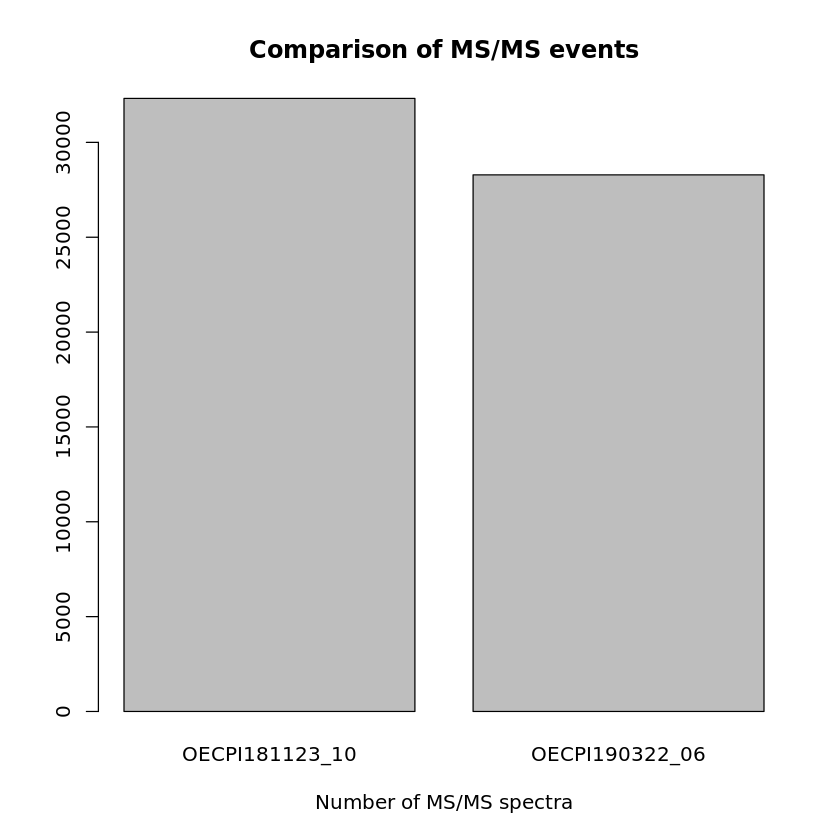

In [17]:
sample1811_ms2_count <- dbGetQuery(sqlite1811, "SELECT count(*) as n FROM spectrum WHERE ms_level = 2")
sample1903_ms2_count <- dbGetQuery(sqlite1903, "SELECT count(*) as n FROM spectrum WHERE ms_level = 2")

hela_ms2_count <- c(sample1811_ms2_count$n,sample1903_ms2_count$n)
barplot(hela_ms2_count, main="Comparison of MS/MS events",  xlab="Number of MS/MS spectra",
        names.arg=c("OECPI181123_10", "OECPI190322_06"))

#### Add your answers here
(double-click here to edit the cell)

##### Question I:  <ins>Do you observe a signficative difference in terms of the number of MS/MS events?</ins>

_Answer_


Since we have the raw data of an HeLa mixture we could compare it to our previous HeLa reference (OVMMA190417_13):

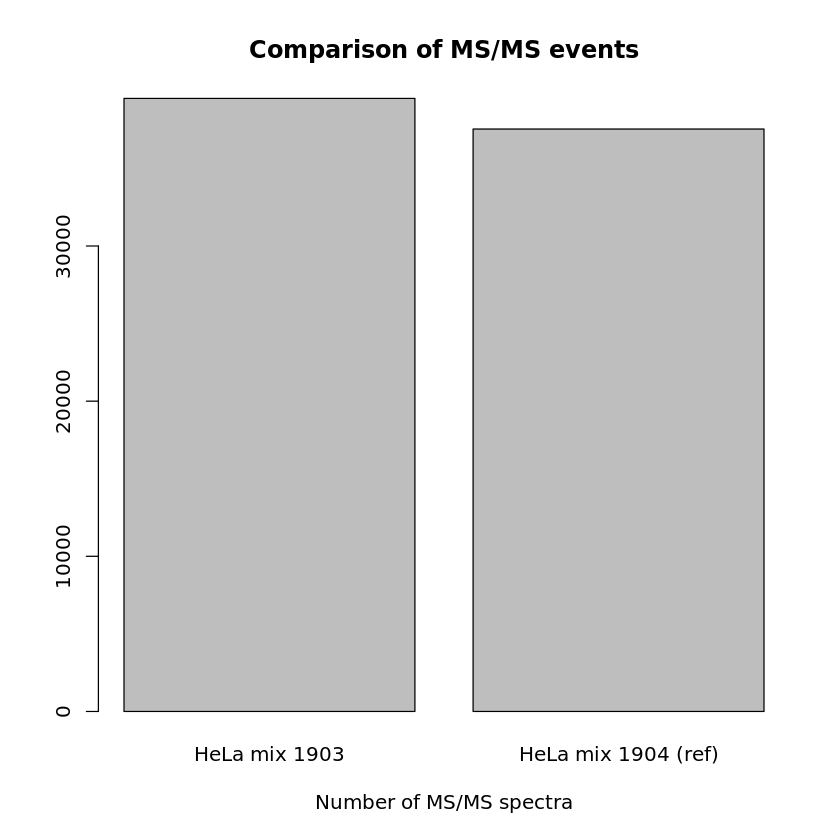

In [18]:
helaSample1903 <- "/mnt/samples/OECPI190322_09.raw.mzDB"
OVMMA190417_13 <- "/mnt/hela/OVMMA190417_13.raw.mzDB"

sqliteHela1903 <- dbConnect(RSQLite::SQLite(), helaSample1903)
sqlite_hela_OVMMA190417_13 <- dbConnect(RSQLite::SQLite(), OVMMA190417_13)

hela1903_ms2_count <- dbGetQuery(sqliteHela1903, "SELECT count(*) as n FROM spectrum WHERE ms_level = 2")
hela1904_ms2_count <- dbGetQuery(sqlite_hela_OVMMA190417_13, "SELECT count(*) as n FROM spectrum WHERE ms_level = 2")

hela_ms2_count <- c(hela1903_ms2_count$n,hela1904_ms2_count$n)
barplot(hela_ms2_count, main="Comparison of MS/MS events",  xlab="Number of MS/MS spectra",
       names.arg=c("HeLa mix 1903", "HeLa mix 1904 (ref)"))

#### Add your answers here
(double-click here to edit the cell)

##### Question I:  <ins>Can you draw any conclusion from these results?</ins>

_Answer_


Let's compare the total ion chromatograms to see if can get more information there. We can start with the HeLa mixtures and then also do it for our samples.

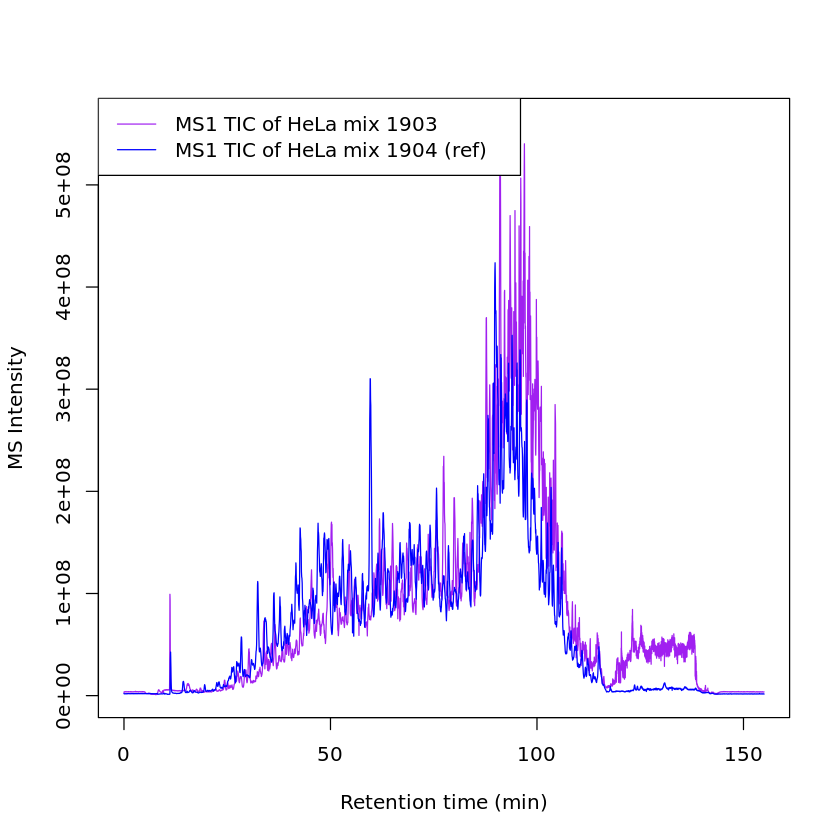

In [19]:
hela1903_ms1_tic <- dbGetQuery(sqliteHela1903, "SELECT (time / 60) as rt, tic as intensity FROM spectrum WHERE ms_level = 1")
hela1904_ms1_tic <- dbGetQuery(sqlite_hela_OVMMA190417_13, "SELECT (time / 60) as rt, tic as intensity FROM spectrum WHERE ms_level = 1")

plot(hela1903_ms1_tic$rt,hela1903_ms1_tic$intensity, type="l", col="purple", lwd=1, xlab="Retention time (min)", ylab="MS Intensity")
lines(hela1904_ms1_tic$rt,hela1904_ms1_tic$intensity, type="l", col="blue", lwd=1)
legend("topleft",c("MS1 TIC of HeLa mix 1903","MS1 TIC of HeLa mix 1904 (ref)"), lwd=c(1,1), col=c("purple","blue"))

Let's do the same plot on our samples of interest:

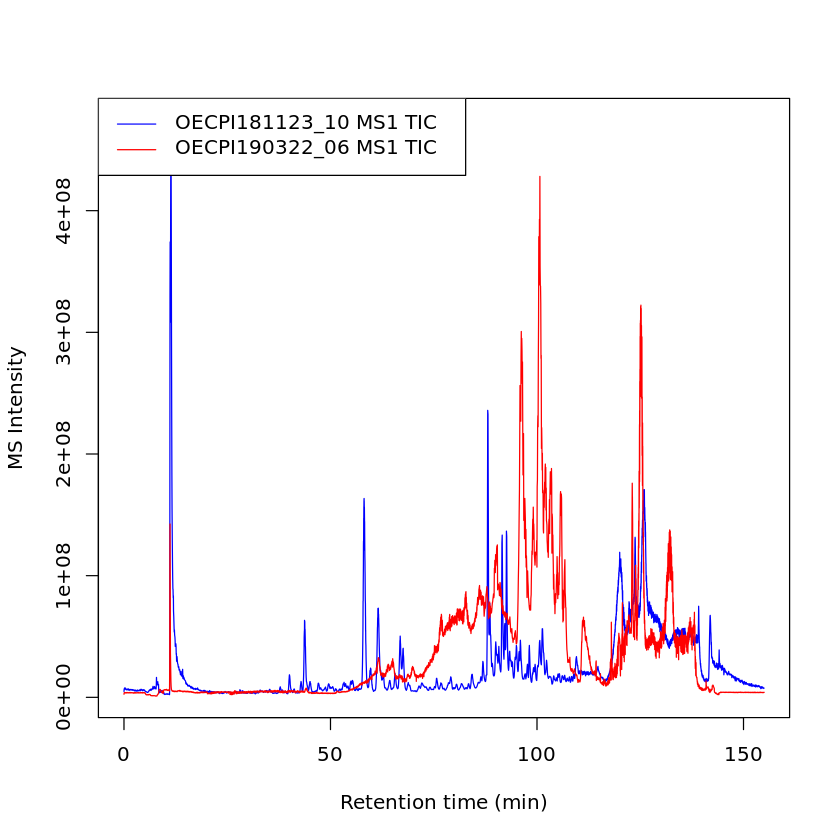

In [20]:
df1811_ms1_tic <- dbGetQuery(sqlite1811, "SELECT (time / 60) as rt, tic as intensity FROM spectrum WHERE ms_level = 1")
df1903_ms1_tic <- dbGetQuery(sqlite1903, "SELECT (time / 60) as rt, tic as intensity FROM spectrum WHERE ms_level = 1")

plot(df1811_ms1_tic$rt,df1811_ms1_tic$intensity, type="l", col="blue", lwd=1, xlab="Retention time (min)", ylab="MS Intensity")
lines(df1903_ms1_tic$rt,df1903_ms1_tic$intensity, type="l", col="red", lwd=1)
legend("topleft",c("OECPI181123_10 MS1 TIC","OECPI190322_06 MS1 TIC"), lwd=c(1,1), col=c("blue","red"))

### This commented code can be used to perform the Base Peak Chromatogram ###
#df1811_ms1_bpc <- dbGetQuery(sqlite1811, "SELECT time,base_peak_intensity as intensity FROM spectrum WHERE ms_level = 1")
#df1903_ms1_bpc <- dbGetQuery(sqlite1903, "SELECT time,base_peak_intensity as intensity FROM spectrum WHERE ms_level = 1")
#plot(df1811_ms1_bpc$time,df1811_ms1_bpc$intensity, type="l", col="blue", lwd=1, xlab="time", ylab="intensity")
#lines(df1903_ms1_bpc$time,df1903_ms1_bpc$intensity, type="l", col="red", lwd=1)
#legend("topleft",c("OECPI181123_10 MS1 BPC","OECPI190322_06 MS1 BPC"), lwd=c(1,1), col=c("blue","red"))

#### Add your answers here
(double-click here to edit the cell)

##### Question I:  <ins>Do you see significative differences between the compared TICs?</ins>

_Answer_

##### Question II:  <ins>Can you draw any conclusion from these results?</ins>

_Answer_


Let's check if the MS/MS TICs are more informative. We will start with the comparison of HeLa mixtures:

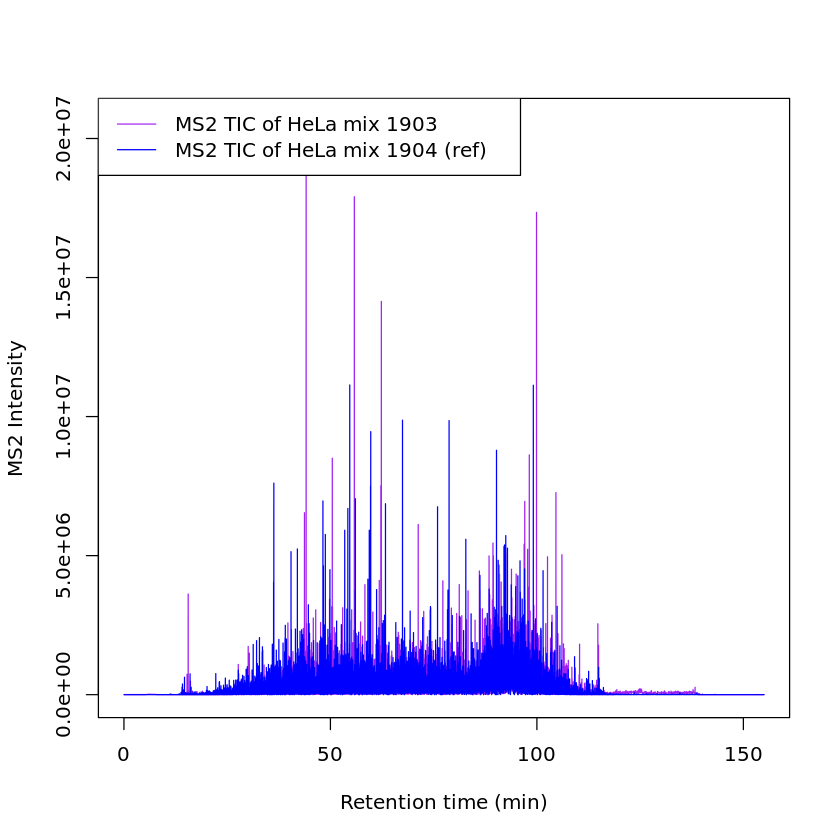

In [21]:
hela1903_ms2_tic <- dbGetQuery(sqliteHela1903, "SELECT (time / 60) as rt, tic as intensity FROM spectrum WHERE ms_level = 2")
hela1904_ms2_tic <- dbGetQuery(sqlite_hela_OVMMA190417_13, "SELECT (time / 60) as rt, tic as intensity FROM spectrum WHERE ms_level = 2")

plot(hela1903_ms2_tic$rt,hela1903_ms2_tic$intensity, type="l", col="purple", lwd=1, xlab="Retention time (min)", ylab="MS2 Intensity")
lines(hela1904_ms2_tic$rt,hela1904_ms2_tic$intensity, type="l", col="blue", lwd=1)
legend("topleft",c("MS2 TIC of HeLa mix 1903","MS2 TIC of HeLa mix 1904 (ref)"), lwd=c(1,1), col=c("purple","blue"))

Try to use the next cell to do the same MS2 TIC analysis on the compared samples:

From the MS/MS TIC we can see very intense and frequently fragmented species. We will now query to mzDB files to search for the 10 most intense precursor ions.

In [22]:
df1903_top10_highest_precs <- dbGetQuery(sqlite1903, "SELECT main_precursor_mz as mz, (time / 60) as rt FROM spectrum WHERE ms_level = 2 ORDER BY tic DESC LIMIT 10")
df1903_top10_highest_precs

mz,rt
<dbl>,<dbl>
737.7097,96.38184
762.0651,100.92056
421.7594,80.21045
421.7596,78.13428
421.7592,79.18138
421.7599,81.24572
421.7594,77.11600
421.7596,82.27640
421.7595,76.08525


Remark: from this table we can see that one precursor is both intense and frequently selected. 

#### Add your answers here
(double-click here to edit the cell)

##### Question:  <ins>Do you have you an idea of the peptide that could correspond to this m/z value? Search in google with "peptide XXX" where XXX is the m/z value of this precursor ion (take only 3 decimals).</ins>

_Answer_



Let's try to do extract chromatograms for this precursor ion in different files.

In [23]:
mzdb1811 <- new(MzDb, sample1811)
mzdb1903 <- new(MzDb, sample1903)
mzdbHela1903 <- new(MzDb, helaSample1903)

In [24]:
chromX1811 <- new (MzDbExtractor, mzdb1811)
chromX1903 <- new (MzDbExtractor, mzdb1903)
chromXHela1903 <- new (MzDbExtractor, mzdbHela1903)

Set the precursor m/z value in the next cell before executing it:

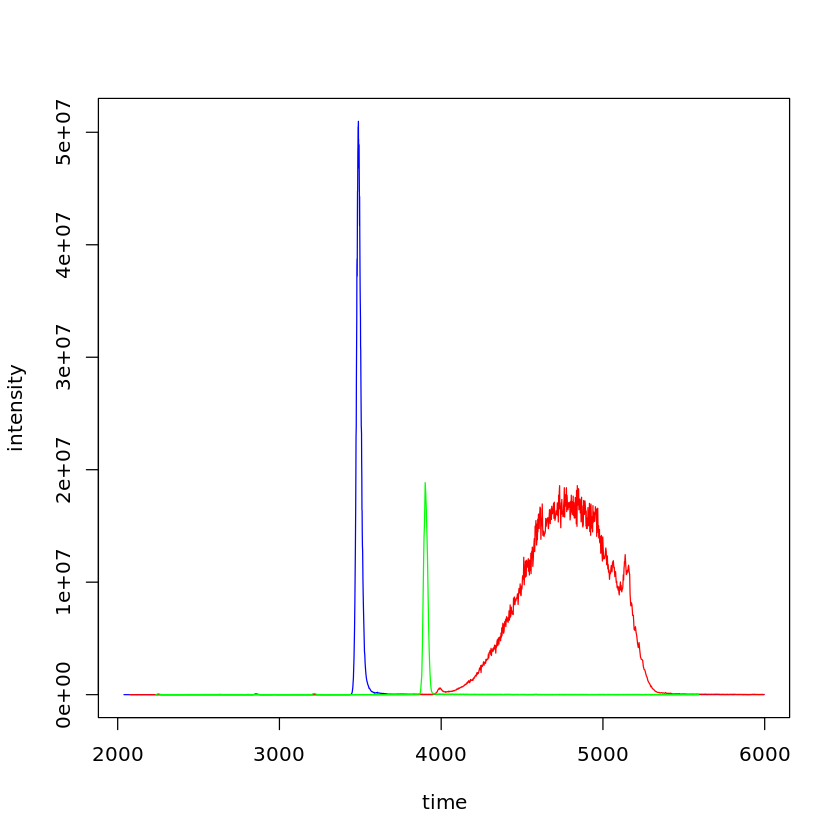

In [25]:
precursor_mz <- 421.759 ### replace this zero value by the m/z of precursor ion you previously selected
precursor_chrom_1811 <- chromX1811$get_xic(precursor_mz,0.001,2000,6000,1,-1)
precursor_chrom_1903 <- chromX1903$get_xic(precursor_mz,0.001,2000,6000,1,-1)
precursor_chrom_hela <- chromXHela1903$get_xic(precursor_mz,0.001,2000,6000,1,-1)

plot(precursor_chrom_1811[,1],precursor_chrom_1811[,2], type="l", col="blue", lwd=1, xlab="time", ylab="intensity")
lines(precursor_chrom_1903[,1],precursor_chrom_1903[,2], type="l", col="red", lwd=1)
lines(precursor_chrom_hela[,1],precursor_chrom_hela[,2], type="l", col="green", lwd=1)

#### Add your answers here
(double-click here to edit the cell)

##### Question I:  <ins>What do you think about the shape of XIC of the selected precursor in the sample where we had identification issues?</ins>

_Answer_

##### Question II:  <ins>What should be done to solve these issues?</ins>

_Answer_


The experimentalist tried to change the conditions of sample preparation by using another kind of gel.

Try to use the next cells to analyze the file "OECPI190330_43.raw.mzDB" and check if the issues remained in the new acquisition:

In [26]:
sample190330 <- "/mnt/samples/OECPI190330_43.raw.mzDB"
sqlite190330 <- dbConnect(RSQLite::SQLite(), sample190330)

In [27]:
### Finally disconnect all databases ###
dbDisconnect(sqlite1811)
dbDisconnect(sqlite1903)
dbDisconnect(sqlite190330)
dbDisconnect(sqliteHela1903)
dbDisconnect(sqlite_hela_OVMMA190417_13)